# Project for Wikishop

Wikishop online store launches a new service. Now users can edit and supplement product descriptions, as in wiki communities. That is, clients offer their edits and comment on the changes of others. The store needs a tool that will search for toxic comments and send them for moderation. 

We need to train the model to classify comments into positive and negative. We have at our disposal a data set with markup on the toxicity of edits.

It is necessary to build a model with the value of the quality metric *F1* at least 0.75. 

**Data description**

The data is in the file `toxic_comments.csv'. The *text* column in it contains the comment text, and *toxic* is the target attribute.

In [1]:
!pip install catboost
!pip install spacy

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import spacy
from sklearn.metrics import accuracy_score, f1_score
#from pathlib import Path
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import word_tokenize,pos_tag
import re
import tqdm
from tqdm import tqdm
from pathlib import Path

## Data exploration and preprocessing

In [3]:
try:
    df = pd.read_csv('toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [4]:
df.sample(10)

,text,toxic
29390,Why is this about Japan? \n\nWhy does this art...,0
137011,"""\n\nThe user Goldorack keeps on reverting the...",0
42154,"Keep. 21:19, 14 Dec 2004 (UTC)",0
94882,"""\nFound my error, it appears I saved the thum...",0
18065,"""\n\n Council Chairman & Mayor \nThe tables li...",0
18973,"blocking will stop nothing, acting like you're...",0
52606,"I don't think it's a bug anymore, I think it w...",0
36649,Host desecration \n\nAssistance of what sort? ...,0
148318,", 28 February 2008 (UTC)\nAnd no content. Ther...",0
81931,"Good article, though lacking in balance\nKudos...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


0    0.898388
1    0.101612
Name: toxic, dtype: float64


<AxesSubplot:>

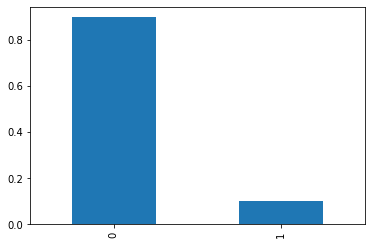

In [6]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

We can notice that:
1) The number of rows in the dataset is 159,292.

2) Comments are provided in English. 

3) The data is not balanced on the basis of toxic. There is a preponderance towards the values of 0.

Given this information, we will pre-process the comments.
In this project we will use the Space Method. Since the comments are in English, we will use stop words for it.

Let's prepare the functions for lemmatization.

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemma_by_spacy_clear(text):
    doc = nlp(text)
    doc=" ".join([token.lemma_ for token in doc])
    doc=re.sub(r'[^a-zA-Z ]',' ',doc)
    return " ".join(doc.split())

#def lemma_by_spacy_clear(text):
    #return " ".join([token.lemma_ for token in nlp(text)])

In [8]:
#corpus_lemma=df.apply(lemma_by_spacy_clear)
df['lemm_text']=df['text'].apply(lemma_by_spacy_clear)

In [9]:
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,D aww he match this background colour I be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I be really not try to edit war it be ...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Lemmatization has been carried out. For further training of models, we will translate the lemmas into vector form.

To do this, we will use the TF-IDF values.

In [10]:
train, test = train_test_split(df, test_size=0.25, random_state=12345, stratify = df['toxic'])


nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

corpus_train = train['lemm_text']
corpus_test = test['lemm_text']

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
features_train = tf_idf_train
target_train = train['toxic']
features_test = tf_idf_test
target_test = test['toxic']

## Machine learning

In [13]:
%%time
mod_logist_regr = LogisticRegression()

param_logist_regr = {'C' : range(1, 4),
                     'penalty': [ 'l2', None],
                     'solver' : ['lbfgs', 'liblinear','newton-cg', 'newton-cholesky', 'sag'],
                     #'multi_class': ['auto', 'ovr'],
                     'max_iter': [500],
                     'class_weight' : ['balanced']}

grid_logist_regr = GridSearchCV(mod_logist_regr, param_logist_regr ,cv=3, scoring = 'f1')
grid_logist_regr.fit(features_train, target_train)

print('Лучшие параметры DecisionTreeClassifier:', grid_logist_regr.best_params_)
print(f'Лучшее значение F1-score: {grid_logist_regr.best_score_}')

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 434, in _check_solver
    raise ValueError("Logistic Regression supports only solvers in %s, got"
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got newton-cholesky.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-pack

Лучшие параметры DecisionTreeClassifier: {'C': 3, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Лучшее значение F1-score: 0.7593882966718493
CPU times: user 8min, sys: 7min 17s, total: 15min 17s
Wall time: 15min 18s


In [18]:
%%time
mod_cat_class = CatBoostClassifier()

param_cat_class = {'loss_function': ['Logloss'],
                  'iterations' : [500],
                  'depth': range (2, 6, 1), 
                  #'min_samples_split' : range (2, 4, 1),
                  'auto_class_weights' : ['Balanced']
                  }

grid_cat_class = GridSearchCV(mod_cat_class, param_cat_class ,cv=3, scoring = 'f1')
grid_cat_class.fit(features_train, target_train)

print('Лучшие параметры DecisionTreeClassifier:', grid_cat_class.best_params_)
print(f'Лучшее значение F1-score: {grid_cat_class.best_score_}')

Learning rate set to 0.126118
0:	learn: 0.6567382	total: 429ms	remaining: 3m 33s
1:	learn: 0.6369376	total: 888ms	remaining: 3m 41s
2:	learn: 0.6249954	total: 1.32s	remaining: 3m 39s
3:	learn: 0.6178545	total: 1.76s	remaining: 3m 38s
4:	learn: 0.6080975	total: 2.22s	remaining: 3m 39s
5:	learn: 0.6032571	total: 2.65s	remaining: 3m 38s
6:	learn: 0.5942077	total: 3.09s	remaining: 3m 37s
7:	learn: 0.5877570	total: 3.54s	remaining: 3m 37s
8:	learn: 0.5839442	total: 4s	remaining: 3m 38s
9:	learn: 0.5781612	total: 4.43s	remaining: 3m 37s
10:	learn: 0.5688304	total: 4.87s	remaining: 3m 36s
11:	learn: 0.5657894	total: 5.31s	remaining: 3m 35s
12:	learn: 0.5610439	total: 5.75s	remaining: 3m 35s
13:	learn: 0.5538477	total: 6.19s	remaining: 3m 34s
14:	learn: 0.5514142	total: 6.62s	remaining: 3m 34s
15:	learn: 0.5489331	total: 7.05s	remaining: 3m 33s
16:	learn: 0.5447377	total: 7.49s	remaining: 3m 32s
17:	learn: 0.5418224	total: 7.92s	remaining: 3m 32s
18:	learn: 0.5370120	total: 8.38s	remaining: 3m

### Conclusion
Logistic regression showed the best result for the F1 metric.

Test sample

In [19]:
mod_logist_regr = grid_logist_regr.best_estimator_

pred_test = mod_logist_regr.predict(features_test)
print(f'F1 на тестовой выборке:{f1_score(target_test, pred_test)}')

F1 на тестовой выборке:0.7689558905639309


## Results of the research

According to the results:

1) Lemmatization of text in 159000 lines using the SpaCy library. Lemmatization takes about 15 minutes, which is acceptable in time.

2) When training models, as well as subsequent testing on a test sample, Logistic regression with the following parameters showed itself best {'C': 3, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}

3) The F1 metric was reached on the test sample of more than 0.75.